<a href="https://colab.research.google.com/github/yajuna/tmath307/blob/master/DE_with_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Machine learning, in particular neural networks, have recently been applied in scientific computing problems. This notebook plays with the diea, and shows an example of solving a ordinary differential equation with tensorflow, given initial condition. The code is adapted from (PINNs)

https://github.com/janblechschmidt/PDEsByNNs

Consider an example ODE

$\frac{dy}{dt} = ay$

with initial condition $y(0)=y_0$.

We solve the problem on the interval `[tmin,tman]`.

With the idea of PINN, we aim to minimize the residual $\frac{dy}{dt} - ay$

In [12]:
# import numpy and Tensorflow
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# tf.experimental.numpy.experimental_enable_numpy_behavior()

In [13]:
# Set date type
DTYPE = 'float32'
tf.keras.backend.set_floatx(DTYPE)

EPOCH = 5000

# set constant- need to be tensors
pi = tf.constant(np.pi, dtype = DTYPE)
a = 1
t_0 = tf.constant([0], dtype = DTYPE)
y_0 = tf.constant([1.], dtype=DTYPE)
N_0 = 50
time_interval = [0., 2.] #

# convert constants to tensor; need [] outside of time_interval[j] to work correctly
tmin = tf.constant([time_interval[0]], dtype=DTYPE)
tmax = tf.constant([time_interval[1]], dtype=DTYPE)

# define the residual

def residual(t, y, y_t):
  return y_t - a * y

Experiment with time variable assignment
1. With random uniform assignment
2. With linear interpolation.

In [14]:
# t is assigned randomly
t = tf.random.uniform((N_0,1), tmin, tmax, dtype=DTYPE)

# t is assigned use linear space
# t = tf.linspace(tmin, tmax, N_0)

Set up model.

This is a sequential model, set up by adding layers one by one.

The variable t is first scaled to be from [tmin, tmax] to [0,1]. This is to help the activation function.

The model has 8 hidden layer, with 20 neurons each. The input is 1 dimensional, and takes time; the output is 1 dimensional, and outputs the function $y(t)$.

In [15]:
def init_model(num_hidden_layers=8, num_neurons_per_layer=20):
    # Initialize a feedforward neural network
    model = tf.keras.Sequential()

    # Input is one-dimensional (time)
    model.add(tf.keras.Input(shape=(1,)))

    # Introduce a scaling layer to map input to [tmin, tmax]
    scaling_layer = tf.keras.layers.Lambda(
                lambda t: 2.0*(t - tmin)/(tmax - tmin) - 1.0)
    model.add(scaling_layer)

    # Append hidden layers
    for _ in range(num_hidden_layers):
        model.add(tf.keras.layers.Dense(num_neurons_per_layer,
            activation=tf.keras.activations.get('tanh'),
            kernel_initializer='glorot_normal'))

    # Output is one-dimensional
    model.add(tf.keras.layers.Dense(1))

    return model

Compute loss and gradient.

In [16]:
def get_residual(model, t):

    # A tf.GradientTape is used to compute derivatives in TensorFlow
    with tf.GradientTape(persistent=True) as tape:

        # Variables t is watched during tape
        # to compute derivatives y_t
        tape.watch(t)

        # Determine residual
        y = model(t)
        # print("print type of y, size of y", type(y), y.size)
    y_t = tape.gradient(y, t)
    # print("print type of y, size of y", type(y_t), y_t.size)
    del tape

    return residual(t, y, y_t)

Compute loss

In [17]:
def compute_loss(model, t, t_0, y_0):

    # Compute mean square of residual for non initial values
    r = get_residual(model, t)
    non_ic_r = tf.reduce_mean(tf.square(r))

    # first part of loss
    loss = non_ic_r

    # Add loss at initial condition

    y_pred = model(t_0)
    loss += tf.reduce_mean(tf.square(y_0 - y_pred))

    return loss

Compute the gradient of the loss function (computed above) with respect to the unknown variables in the model (trainable_variables in Tensorflow). This is also done via GradientTape, but now it keeps track of the parameters (weights, biases) in our model. These parameters can be accessed by model.trainable_variables.

In [18]:

model = init_model()
loss = compute_loss(model, t, t_0, y_0)

In [19]:
def get_grad_of_loss(model, t, t_0, y_0):

    with tf.GradientTape(persistent=True) as tape:
        # This tape is for derivatives with
        # respect to trainable variables
        # tape.watch(model.trainable_variables)
        loss = compute_loss(model, t, t_0, y_0)

    g = tape.gradient(loss, model.trainable_variables)
    del tape

    return loss, g

Set up optimizer and train model.

Next we initialize the model, set the learning rate to the step function

$$
\delta(n) = 0.01 \, \textbf{1}_{\{n < 1000\}} + 0.001 \, \textbf{1}_{\{1000 \le n < 3000\}} + 0.0005 \, \textbf{1}_{\{3000 \le n\}}
$$

which decays in a piecewise constant fashion, and set up a `tf.keras.optimizer` to train the model. Notice the learning rate decreases as the training goes on.

In [20]:
# Initialize model aka y_\theta
model = init_model(num_hidden_layers=2)

# We choose a piecewise decay of the learning rate, i.e., the
# step size in the gradient descent type algorithm
# the first 1000 steps use a learning rate of 0.01
# from 1000 - 3000: learning rate = 0.001
# from 3000 onwards: learning rate = 0.0005

lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([1000,3000],[1e-2,1e-3,5e-4])

# Choose the optimizer
optim = tf.keras.optimizers.Adam(learning_rate=lr)

Train the model for  𝑁=5000  epochs. Here, we set up a function `train_step()` which performs one training step.

Note: The `@tf.function` is a so-called `Decorator` within Python. This particular decorator redefines the function that follows, in our case `train_step`, as a TensorFlow graph which may speed up the training significantly.

In [21]:
from time import time

# add function wrapper to increase speed of training
@tf.function
def train_step():
    # Compute current loss and gradient w.r.t. parameters
    loss, grad_theta = get_grad_of_loss(model, t, t_0, y_0)

    # Perform gradient descent step
    optim.apply_gradients(zip(grad_theta, model.trainable_variables))

    return loss

# Number of training epochs
N = EPOCH
hist = []

# Start timer
t0 = time()

for i in range(N + 1):

    loss = train_step()

    # Append current loss to hist
    hist.append(loss.numpy())

    # Output current loss after 50 iterates
    if i%500 == 0:
        print('It {:05d}: loss = {:10.8e}'.format(i,loss))

# Print computation time
print('\nComputation time: {} seconds'.format(time()-t0))

It 00000: loss = 1.45917702e+00
It 00500: loss = 1.04590657e-03
It 01000: loss = 9.25919414e-03
It 01500: loss = 3.42127387e-05
It 02000: loss = 2.96524122e-05
It 02500: loss = 2.55096420e-05
It 03000: loss = 2.19657304e-05
It 03500: loss = 2.03330947e-05
It 04000: loss = 1.86977959e-05
It 04500: loss = 1.70887379e-05
It 05000: loss = 1.55217112e-05

Computation time: 5.712350845336914 seconds


Visualize

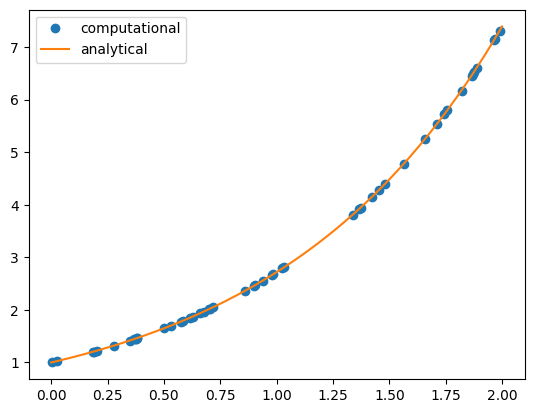

In [22]:
y = model(t).numpy().reshape(len(t))

tt = tf.linspace(tmin, tmax, N_0)

gold = tf.exp(tt)

fig, ax = plt.subplots()
ax.plot(t, y, 'o', label = 'computational')
ax.plot(tt, gold, label = 'analytical') # '*',
ax.legend()

plt.show()